-1
1.20000000000000
1.30000000000000
7.80000000000000
6.10000000000000
5
{0: (-4.0, 7), 2: (-3.0, 7), 4: (-2.0, 7), 9: (-1.0, 7), 12: (0.0, 7), 14: (1.0, 7), 16: (2.0, 7), 19: (3.0, 7), 22: (4.0, 7), 1: (-3.184560925628687, 6), 5: (-1.9214923737689846, 6), 6: (-0.49082670810218076, 6), 13: (0.5179654180606877, 6), 20: (2.138504979710878, 6), 24: (3.373783018941728, 6), 7: (-3.0146590973201914, 5), 11: (-0.8303251058227497, 5), 18: (1.1386555532660165, 5), 25: (3.0200465286121676, 5), 3: (-2.8395539988229817, 4), 17: (-0.12731085237254186, 4), 23: (2.700281382282303, 4), 8: (0.22885195066556857, 3), 10: (0.4964475240250349, 2), 15: (0.9442835822435967, 1), 21: (1.0640995836053078, 0)}


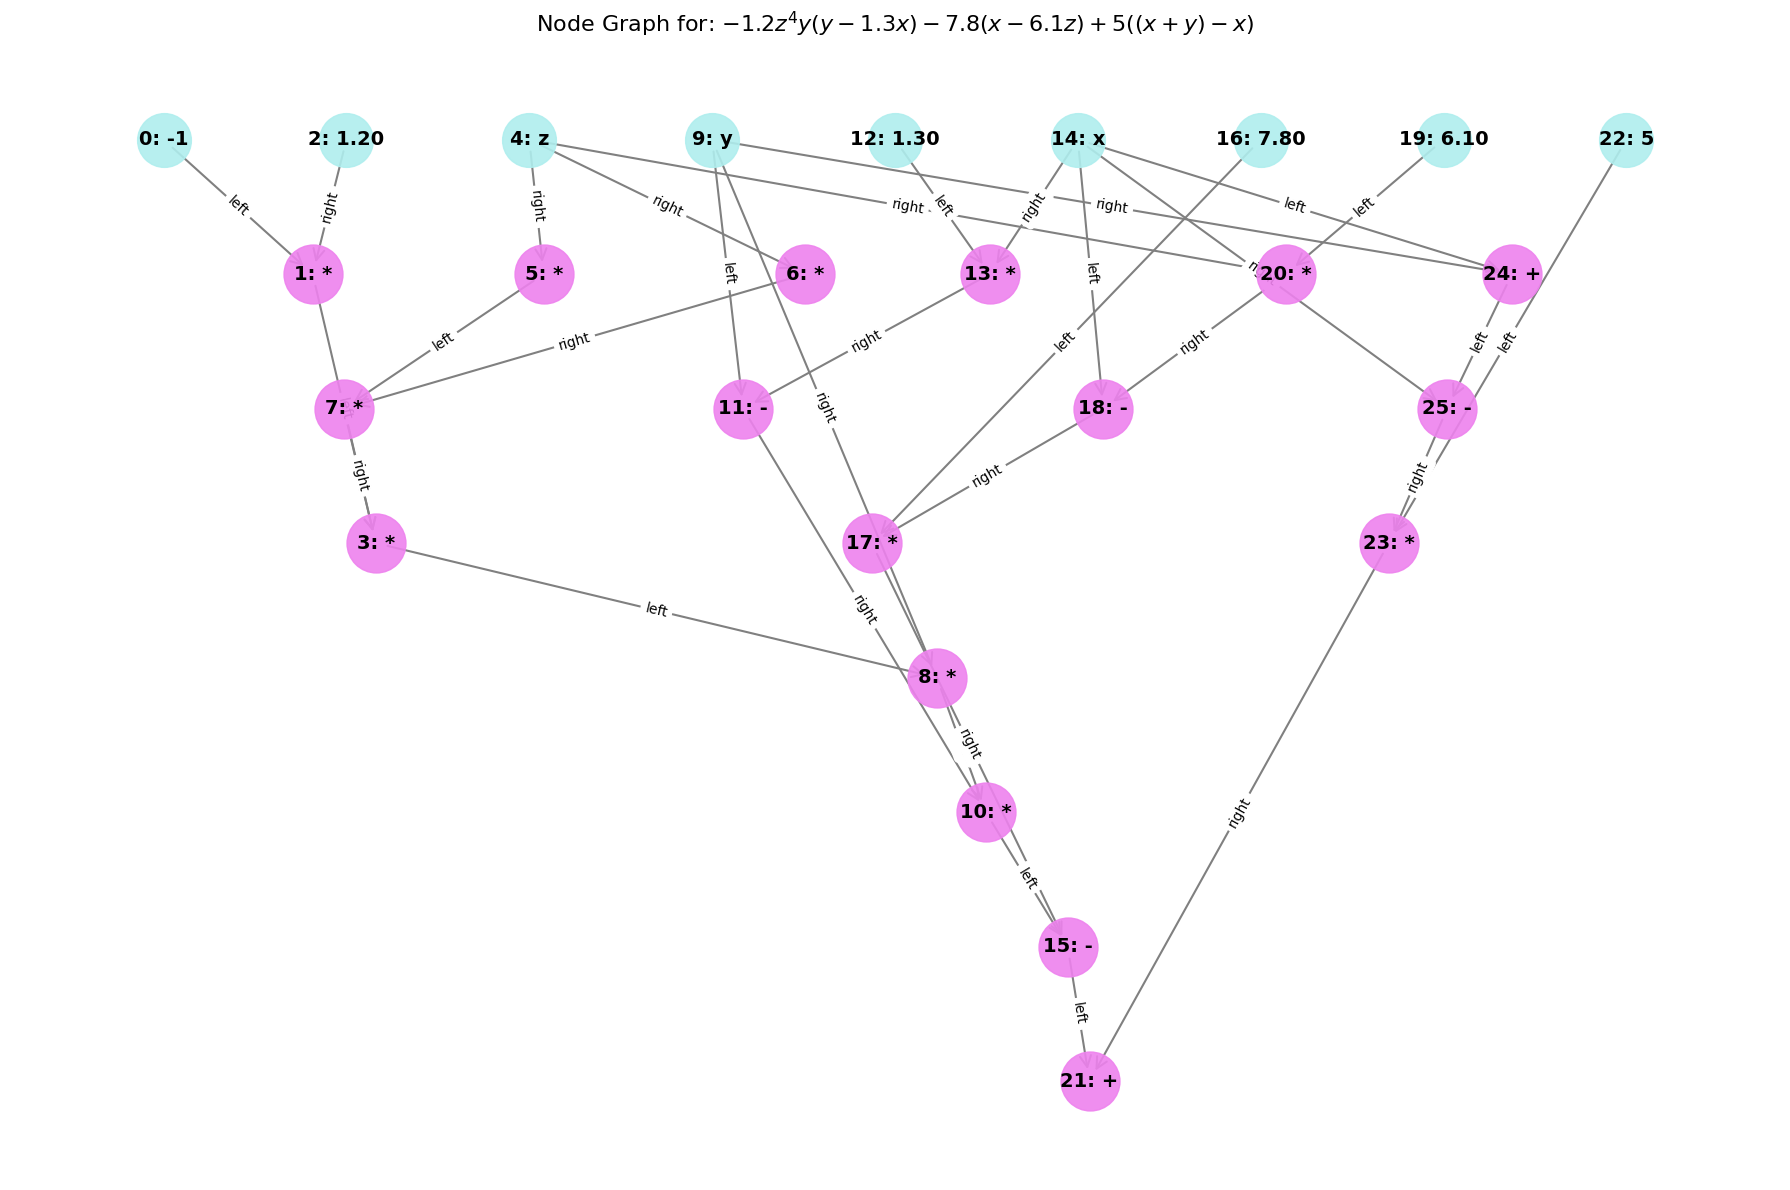

In [304]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application
from collections import deque, defaultdict
import numpy as np
import random
import ast
from copy import deepcopy
import math



class PolynomialParser(ast.NodeVisitor):
    def visit_BinOp(self, node):
        left = self.visit(node.left)
        right = self.visit(node.right)
        op = type(node.op)

        if op == ast.Add:
            return sp.Add(left, right, evaluate=False)
        elif op == ast.Sub:
            return sp.Add(left, sp.Mul(-1, right, evaluate=False), evaluate=False)
        elif op == ast.Mult:
            return sp.Mul(left, right, evaluate=False)
        elif op == ast.Pow:
            return sp.Pow(left, right, evaluate=False)
        
    def visit_UnaryOp(self, node):
        operand = self.visit(node.operand)
        if isinstance(node.op, ast.USub):  # Unary minus: -x
            return sp.Mul(-1, operand, evaluate=False)
    
    def visit_Name(self, node):
        return sp.Symbol(node.id)

    def visit_Constant(self, node): 
        return sp.Number(node.value)

    def visit_Expr(self, node):
        return self.visit(node.value)
    
    def parse(self, expression):
        tree = ast.parse(expression, mode='eval')
        raw_expr = self.visit(tree.body)
        return raw_expr
    


# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, sp.Add) else "*", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, sp.Add):
                label = "+"
            else:
                label = "*"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    if isinstance(expr, sp.Add) and expr_branch.could_extract_minus_sign():
                        # For addition with negative term, create a subtraction node instead
                        parent_node = node_id
                        graph.add_node(parent_node, label="-", type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the term without the negative sign
                        node_id, right_id = process_expression(-expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    else:
                        # Standard addition or multiplication node
                        parent_node = node_id
                        graph.add_node(parent_node, label=label, type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the current term
                        node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id
            else:
                # Handle empty args case (unlikely but for robustness)
                return node_id, None
    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        # Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            # Replace power operation with a binary tree of multiplications
            # For example, x^4 becomes (x*x)*(x*x)
            
            # Handle powers by breaking them into multiplications in binary tree form
            return _handle_power_as_multiplication(expr, base, int(exp), graph, node_id, parent_id, expr_to_id)
            
    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    elif expr.is_number:
        curr_id = node_id
        print(expr)
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(round(expr, 2)), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    else:
        # Default case for any other expression types
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id

def _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    
    # Handle the base case of x^1 (just return the base itself)
    if exp == 1:
        return process_expression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)
    
    # Special case for x^2: Create a multiplication node with two edges from the same x node
    if exp == 2:
        # First, process the base to get its node
        node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
        # Create multiplication node
        mul_node = node_id
        graph.add_node(mul_node, label="*", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        
        # Add two edges from the same base node to the multiplication node
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        
        # Connect to parent if needed
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
            
        return node_id, mul_node
    
    # For exponents > 2, create a binary tree of multiplications
    # For odd exponents: x^n = x * (x^(n-1))
    # For even exponents: x^n = (x^(n/2)) * (x^(n/2))
    if exp % 2 == 0:
        # For even exponents, create a balanced tree
        left_exp = exp // 2
        right_exp = exp // 2
    else:
        # For odd exponents, we'll do x * (x^(n-1))
        left_exp = 1
        right_exp = exp - 1
    
    # Process left part
    if left_exp == 1:
        node_id, left_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        left_power_expr = base ** left_exp
        node_id, left_id = _handle_power_as_multiplication(left_power_expr, base, left_exp, graph, node_id, None, expr_to_id)
    
    # Process right part
    if right_exp == 1:
        node_id, right_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        right_power_expr = base ** right_exp
        node_id, right_id = _handle_power_as_multiplication(right_power_expr, base, right_exp, graph, node_id, None, expr_to_id)
    
    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label="*", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    
    # Connect the operands
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')
    
    # Connect to parent if needed
    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)
        
    return node_id, mul_node





def check_numeric(s):
    s = s.strip()
    try:
        float(s)
        return True
    except ValueError:
        return False

def merge_negatives(G):
    G_mod = deepcopy(G)
    nodes_to_remove = []

    new_node = []
    new_edges = []

    for node in list(G_mod.nodes()):
        if G_mod.nodes[node].get('label') == '*':
            parent_edges = list(G_mod.in_edges(node, data=True))
            
            if len(parent_edges) > 1:
                parent1, parent2 = parent_edges[0][0], parent_edges[1][0]
                
                if (G_mod.nodes[parent1].get('type') == 'value' and 
                    G_mod.nodes[parent2].get('type') == 'value' and
                    check_numeric(G_mod.nodes[parent1].get('label', '')) and 
                    check_numeric(G_mod.nodes[parent2].get('label', ''))):
                    
                    # Calculate new value
                    new_value = (float(G_mod.nodes[parent1]['label']) * float(G_mod.nodes[parent2]['label']))
                    
                    children_edges = list(G_mod.out_edges(node, data=True))
                    nodes_to_remove.append(node)
                    nodes_to_remove.append(parent1)
                    nodes_to_remove.append(parent2)


                    new_node.append(((node, {'label': str(new_value)})))
                    new_edges.append(children_edges[0])

    # Apply all changes

    for i in nodes_to_remove:
        # Remove all edges connected to the node
        G_mod.remove_edges_from(list(G.in_edges(i)))  # Remove incoming edges
        G_mod.remove_edges_from(list(G.out_edges(i)))  # Remove outgoing edges
        
        # Remove the node itself
        G_mod.remove_node(i)



    for i in new_node:
        G_mod.add_node(i[0], label= i[1]['label'], type="value")

    for j in new_edges:
        G_mod.add_edge(j[0], j[1], label = j[2]['label'])


    G_relabelled = relabel_graph(G_mod)
        

    return G_relabelled


def relabel_graph(G):
    old_nodes = sorted(G.nodes())
    new_labels = {old: new for new, old in enumerate(old_nodes)}

    # Relabel nodes
    G_relabelled = nx.relabel_nodes(G, new_labels, copy=True)

    return G_relabelled


def implement_bit_shifts(G):

    remove_vals = [] # Remove the node with the value
    remove_nodes = []  # Contains the multiplocation node. Remove the nodes and its edges
    bit_shift_nodes = [] # Each sub list has the structure: [(... Bit shifts ... , operation), parent node, child node]

    for node in G.nodes():
        if G.nodes[node].get('label', '') == '*' and len(G.in_edges(node)) == 2:
            #print(G.nodes[node])

            edges = list(G.in_edges(node, data = True))
            #print(edges)

            for i, tup in enumerate(edges):
                if(tup[2].get('label', '') == 'left'):
                    left_edge = tup
                else:
                    right_edge = tup

            # If the left edge is not a number, then continue with the loop
            if not check_numeric(G.nodes[left_edge[0]].get('label', '')):
                continue
            
            # print(node)
            val = G.nodes[left_edge[0]].get('label', '')
            best_combination, best_sum = closest_power_of_2(float(val))

            # print( "Node to remove: ", left_edge[0])
            remove_vals.append(left_edge[0]) # Adds the node that is the number

            # print("Multiplication node is: ", node)
            remove_nodes.append(node) # Adds multiplication node whos in edges will be removed
            parent_node = right_edge[0]
            child_node = list(G.out_edges(node))[0][1]
            # print("Parent node is: ", parent_node)
            # print("Child node is: ", child_node)

            bit_shift_nodes.append([best_combination, parent_node, child_node])


    max_id = max(G.nodes()) + 1
    for j, combo in enumerate(bit_shift_nodes):
        multiplication_node = remove_nodes[j] # Related multiplication node that needs to be deleted
        out_edge_label = list(G.out_edges(multiplication_node, data = True))[0][2].get('label', '') 

        node_operation = combo[0][2]

        G.add_node(max_id, label = node_operation, type = "operation")

        operator_id = max_id
        max_id += 1

        for i in [combo[0][0], combo[0][1]]:
            if i < 0:
                label = ">> " + str(abs(i))
            else:
                label = "<< " + str(abs(i))

            if i == combo[0][0]:
                edge_label = "left"
            else:
                edge_label = "right"

            G.add_node(max_id, label= label, type="operation")

            G.add_edge(combo[1], max_id)
            G.add_edge(max_id, operator_id, label = edge_label)
            max_id += 1

        G.add_edge(operator_id, combo[2], label = out_edge_label)



    G.remove_nodes_from(remove_vals)
    for item in remove_nodes:
        G.remove_node(item)

    G = relabel_graph(G)

    return G


def closest_power_of_2(coeff):
    best_sum = None
    closest_diff = float('inf')
    best_combination = None
    
    # Limit the exponents range to consider reasonable powers of 2
    max_exp = 20  # For large numbers (2^20 is 1048576)
    min_exp = -10  # For small numbers (2^-10 is 0.0009765625)

    # Iterate through all possible pairs of powers of 2
    for exp1 in range(min_exp, max_exp + 1):
        for exp2 in range(min_exp, max_exp + 1):
            power1 = 2 ** exp1
            power2 = 2 ** exp2
            
            # Calculate sum (2^exp1 + 2^exp2)
            power_sum = power1 + power2
            diff_sum = abs(coeff - power_sum)
            if diff_sum < closest_diff:
                closest_diff = diff_sum
                best_sum = power_sum
                best_combination = (exp1, exp2, '+')

            # Calculate difference (|2^exp1 - 2^exp2|)
            power_diff = power1 - power2
            diff_diff = abs(coeff - power_diff)
            if diff_diff < closest_diff:
                closest_diff = diff_diff
                best_sum = power_diff
                best_combination = (exp1, exp2, '-')

    return best_combination, best_sum


# Orders nodes based on stages starting from the symbolic characters
def stage_levels(G, node):
    levels = {}
    topo_order = list(nx.topological_sort(G))
    for node in topo_order:
        preds = list(G.predecessors(node))
        if not preds:
            levels[node] = 0
        else:
            levels[node] = max(levels[p] + 1 for p in preds)
    return levels


def organise_nodes_by_level(levels):
    nodes_by_level = {}
    
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)

    return {k: v for k, v in sorted(nodes_by_level.items())}

def custom_layout(G, root):
    pos = {}
    
    levels = stage_levels(G, root)
    nodes_by_level = organise_nodes_by_level(levels)
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(nodes_by_level)
    spacing = 1
    
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        
        if level == 0:
            max_span = (num_nodes - 1) * spacing    
            x_start = -max_span / 2
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * spacing
                y = max_level - level
                pos[node] = (x, y)
                
        else:
            if(num_nodes == 1):
                x_start =  random.uniform(-1.5, 1.5)
            else:
                span = (num_nodes - 1) * (max_span/num_nodes)
                x_start = - span/ 2
                
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * (max_span/num_nodes) + random.uniform(-0.2, 0.2)
                y = max_level - level
                pos[node] = (x, y)     
    
    return pos
    
    

def visualize_polynomial(polynomial_str):
    # Parse the expression
    parser = PolynomialParser()
    expr = parser.parse(polynomial_str)

    
    graph, root_id = create_node_graph(expr)
    display_graph(graph, root_id, polynomial_str)

    return graph, root_id


def display_graph(graph, root_id, polynomial_str):
        
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)

    print(pos)
    
    plt.figure(figsize=(18, 12))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color='violet', alpha=0.9)
    
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)

    edge_labels = nx.get_edge_attributes(graph, 'label')

# Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    
    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    labels = {}
    for node in graph.nodes():
        attr_value = graph.nodes[node].get('label', '')
        labels[node] = f"{node}: {attr_value}"
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')

    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 


#user_input = input("\nEnter a polynomial: ")
user_input = "-x^2 + 4*x^2 + 5.3*((x*y) - z) - 1.01*y*(x+z) + 1.3*(x+ y) - 2.1*(((x+y)^2 + z) - x*y)"
#user_input = "3.2*(x*(4.2*(x*1.2*(x+1)+2)+4)+5)"
# user_input = "x*y + ((w+x)*y + z) - 2.3*((x+y)^2 + z) + 3*(x*y-w)"
# # user_input = "z^2 + (w+x)*y + z"
# user_input = "(z+1)*z - 2.3*(w-x)*y"
user_input = "-1.2*z^4*y*(y- 1.3*x) - 7.8*(x - 6.1*z) + 5*((x + y) - x)"


if user_input.strip():
    user_input = user_input.replace('^', '**')
    G, root = visualize_polynomial(user_input)


## Trace from a minus node right --> left alternate as long as the parent node is a multiplication node

{0: (-3.5, 7), 2: (-2.5, 7), 7: (-1.5, 7), 10: (-0.5, 7), 12: (0.5, 7), 14: (1.5, 7), 17: (2.5, 7), 20: (3.5, 7), 3: (-2.8034709293793365, 6), 4: (-1.425916870166588, 6), 11: (0.06963911603419726, 6), 18: (1.237059748618794, 6), 22: (2.7783995653891584, 6), 5: (-2.631898141078317, 5), 9: (-0.9697237871532167, 5), 16: (0.7137261537658288, 5), 23: (2.6399122894866993, 5), 1: (-2.522073695142436, 4), 15: (0.03594923173045786, 4), 21: (2.186420641264149, 4), 6: (-0.6738382963924594, 3), 8: (-1.1266802764645159, 2), 13: (-0.7020495807111955, 1), 19: (0.837725252978185, 0)}


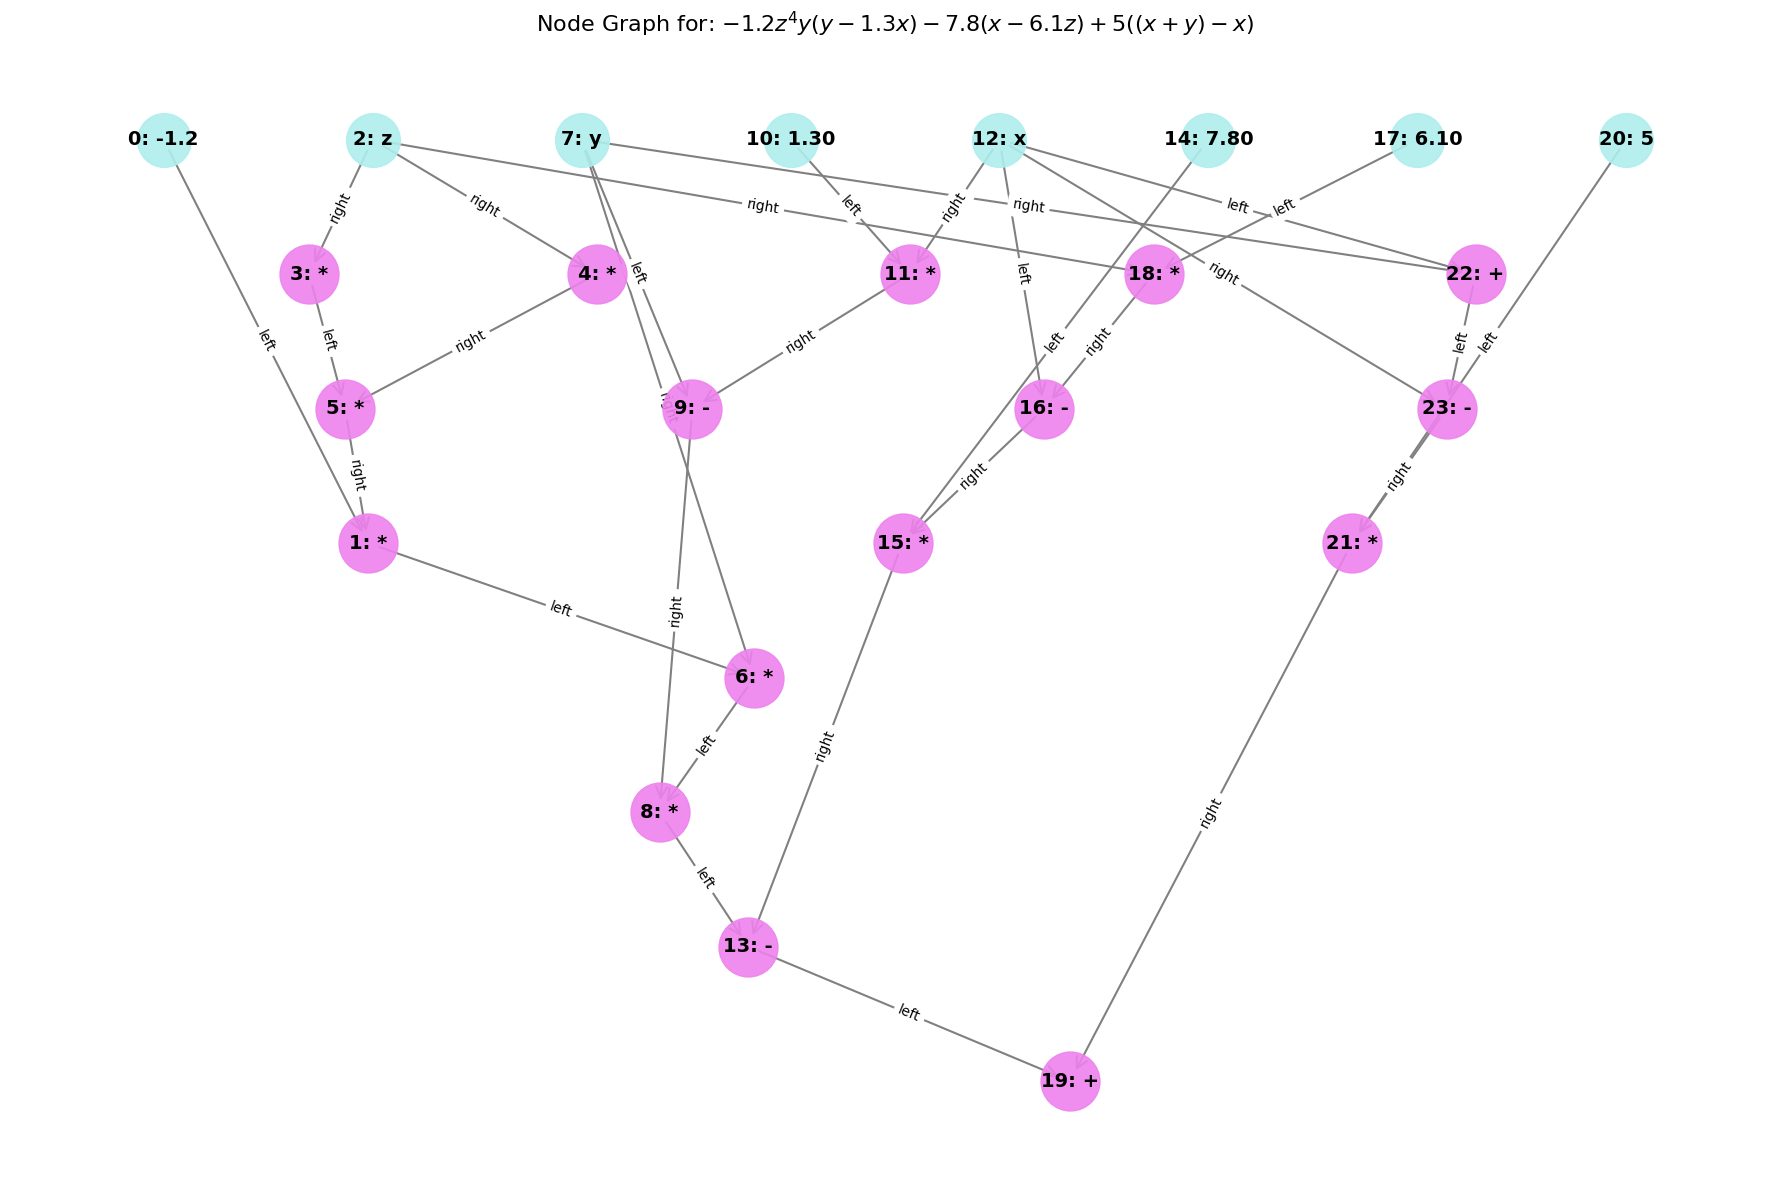

In [305]:
G_mod = merge_negatives(G)
display_graph(G_mod, 0, user_input)

{0: (-1.0, 8), 5: (0.0, 8), 8: (1.0, 8), 1: (-0.7758000043532216, 7), 2: (-0.6152749530260035, 7), 12: (-0.4221890079880956, 7), 18: (-0.1509126067625799, 7), 19: (0.09132359419265634, 7), 24: (0.38328083210860386, 7), 25: (0.955875612186526, 7), 3: (-0.6830314318873427, 6), 13: (-0.27230239574761483, 6), 17: (0.29459192819125396, 6), 23: (0.690761499783316, 6), 7: (-0.8550737261061201, 5), 10: (-0.3848294098580279, 5), 15: (-0.14842160559603462, 5), 16: (0.2522290199720252, 5), 27: (0.3270505900742584, 5), 28: (0.6348912018967512, 5), 14: (-0.7810477668215052, 4), 21: (-0.317095153278973, 4), 22: (0.10946394610659427, 4), 26: (0.8625952291493836, 4), 4: (-0.5953102758524171, 3), 20: (0.46084385576155773, 3), 6: (0.6786597937541721, 2), 9: (0.8434490084391284, 1), 11: (-0.4527869416298864, 0)}


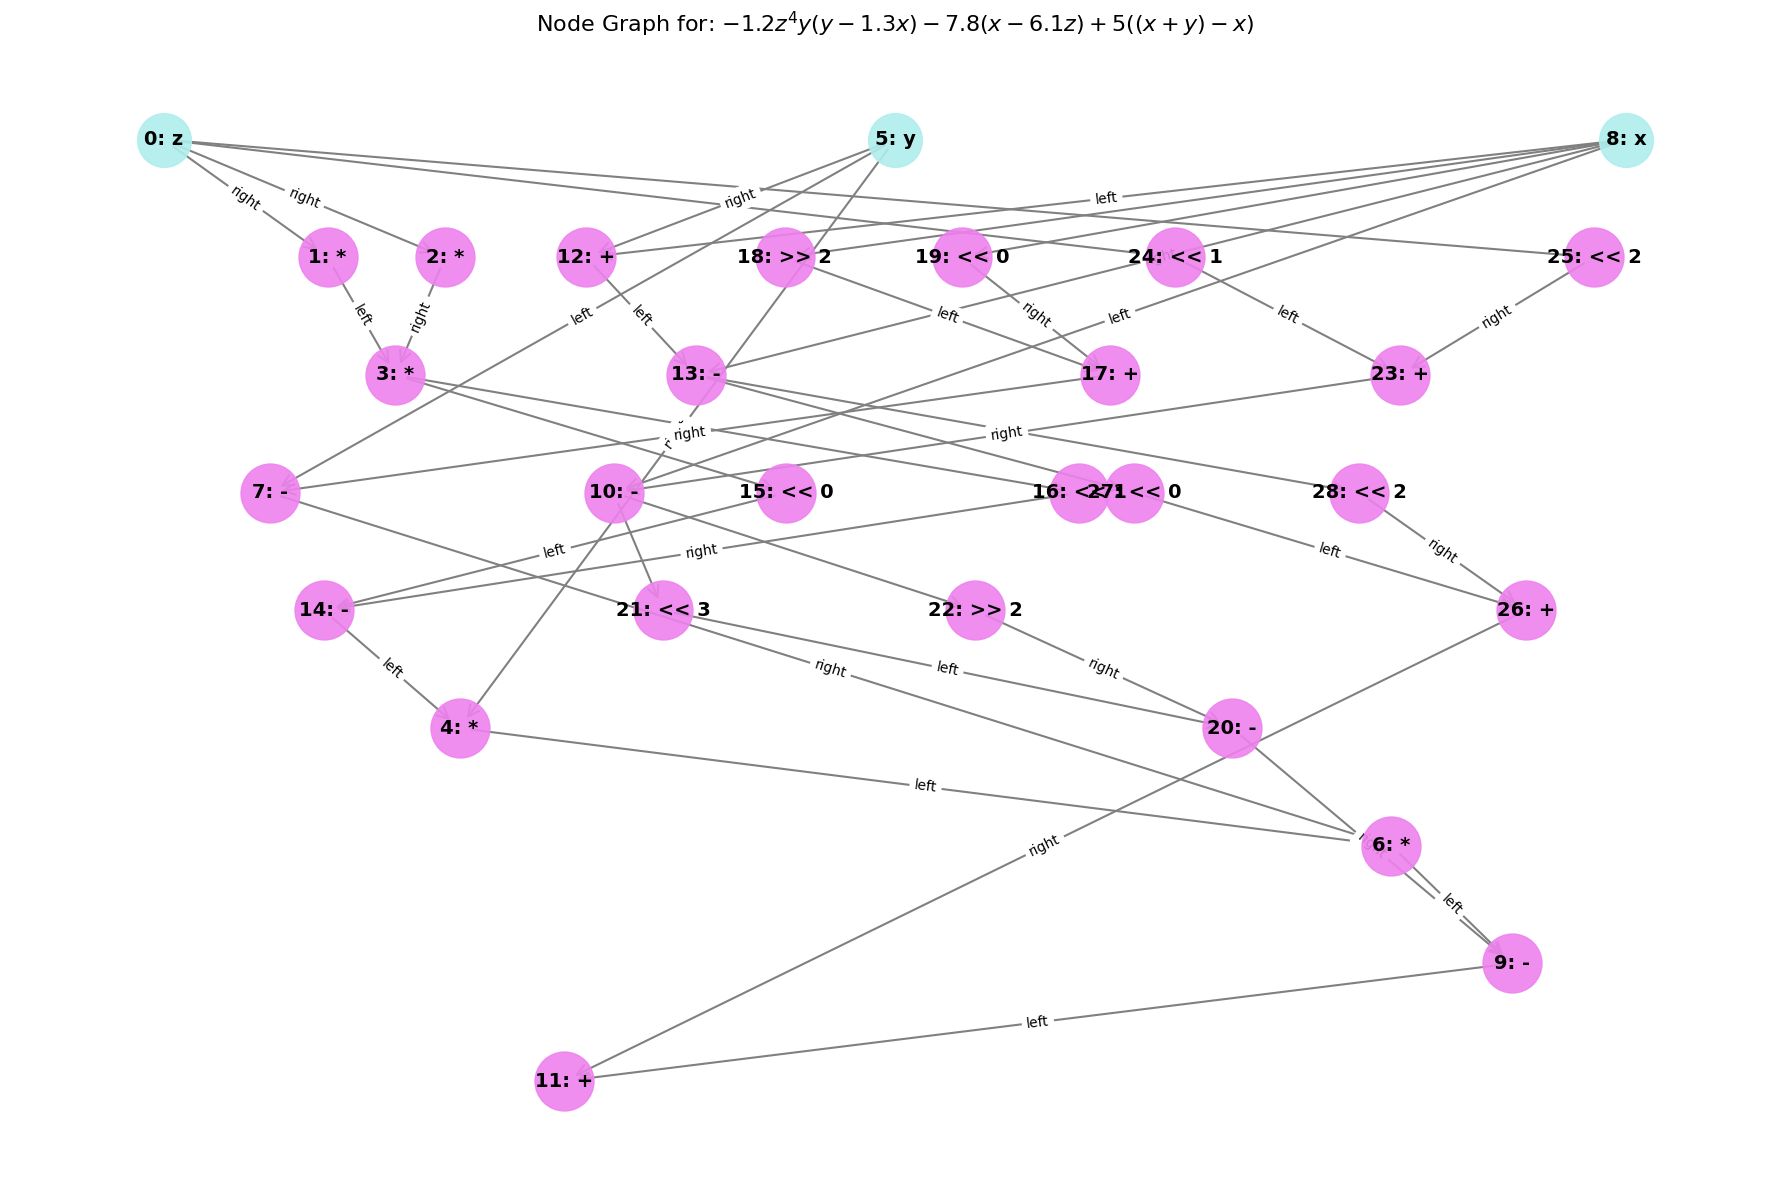

In [307]:
G_mod = implement_bit_shifts(G_mod)
display_graph(G_mod, 0, user_input)

In [ ]:
G_new = deepcopy(G_mod)

for node in G_mod.nodes():
    if G_mod.nodes[node]['label'] == "<< 0":
        print(G_mod.nodes[node]['label'])


        print(list(G_mod.in_edges(node)))

<< 0
[(3, 15)]
<< 0
[(8, 19)]
<< 0
[(13, 27)]


In [282]:
# Example coefficient
coeff = -1.2

# Find closest sum or difference of powers of 2
best_combination, best_sum = closest_power_of_2(coeff)
print(best_sum)

# Output the result
print(f"Target coefficient: {coeff}")
print(f"Closest combination: 2^{best_combination[0]} {'+' if best_combination[2] == 'sum' else '-'} 2^{best_combination[1]}")
print(f"Closest sum or difference: {best_sum}")
print(f"Difference: {abs(coeff - best_sum)}")


-1
Target coefficient: -1.2
Closest combination: 2^0 - 2^1
Closest sum or difference: -1
Difference: 0.19999999999999996


In [33]:
from itertools import product
from collections import defaultdict

def generate_valid_combinations():
    operations = ['+', '-', '*']
    combos_by_length = defaultdict(list)

    for length in range(1, 4):
        for combo in product(operations, repeat=length):
            combo = list(combo)

            if length == 1:
                combos_by_length[1].append(combo)

            elif length == 2:
                # Valid 2-length combos, no restriction on where '*' can go, but only once
                if combo.count('*') <= 1:
                    combos_by_length[length].append(combo)

            elif length == 3:
                # Middle must be '*' and only appear once in the middle
                if combo[1] == '*' and combo.count('*') == 1:
                    combos_by_length[length].append(combo)

    return combos_by_length



combos_by_length = generate_valid_combinations()



In [341]:
def traverse_up_subtractions(G, node, direction='right'):
    # Get incoming edges with data
    edges = G.in_edges(node, data=True)

    # Select parent edge based on current direction
    target_edge = [edge for edge in edges if edge[2].get('label') == direction]

    if not target_edge:
        return node, direction  # No parent in the given direction

    parent_node = target_edge[0][0]
    parent_label = G.nodes[parent_node].get('label')

    if parent_label == "*":
        # Alternate direction and continue recursively
        if direction == 'right':
            next_dir = 'left'
        else:
            next_dir = 'right'

        return traverse_up_subtractions(G, parent_node, next_dir)
    else:
        print(f"Stopping at node {parent_node} with label {parent_label} on the {direction}")
        return parent_node, direction


for node in G.nodes:
    if G.nodes[node]['label'] == "-":
        print("Node is: ", node)
        stop_node, stop_dir = traverse_up_subtractions(G, node, direction='right')

Node is:  7
Stopping at node 8 with label x on the right
Node is:  9
Stopping at node 10 with label 2 on the left
Node is:  12
Stopping at node 2 with label z on the right
Node is:  13
Stopping at node 14 with label 5 on the left
Node is:  17
Stopping at node 8 with label x on the left
Node is:  19
Stopping at node 2 with label z on the right
